In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2
import pathlib
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
  #Downloading the provided dataset from drive.
  !gdown --id 12G5z7fPkS8oMditi4zrMD-nSYw0SMU47
  !unzip -o flowers.zip &> /dev/null

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=12G5z7fPkS8oMditi4zrMD-nSYw0SMU47
To: /content/flowers.zip
100% 164M/164M [00:00<00:00, 345MB/s]


In [3]:
data_dir = 'flowers'

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 12847 files belonging to 13 classes.
Using 10278 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 12847 files belonging to 13 classes.
Using 2569 files for validation.


In [5]:
images = [train_ds.take(1)]
images[0]

<TakeDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
class_names = train_ds.class_names
print(class_names)

['astilbe', 'bellflower', 'black-eyed susan', 'calendula', 'california poppy', 'carnation', 'common daisy', 'coreopsis', 'dandelion', 'iris', 'rose', 'sunflower', 'tulip']


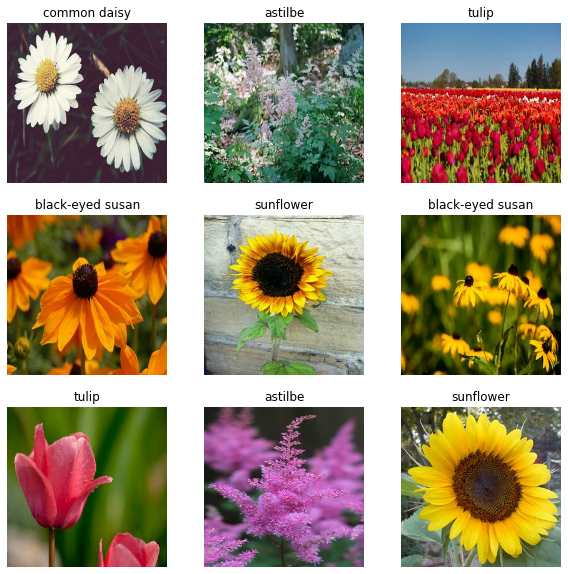

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)

#MobileNetV3Large
base_model_type = tf.keras.applications.MobileNetV3Large
preprocessing = tf.keras.applications.mobilenet_v3.preprocess_input

model_name = str(base_model_type).split(' ')[1]

base_model = base_model_type(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

#Initally keeping all the layers freezed
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocessing(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten(name="flatten")(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(13, activation="softmax")(x)
model = keras.Model(inputs, outputs)


base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

initial_epochs = 10
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 5, 5, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               246016    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


322/322 [==============================] - 13s 29ms/step - loss: 1.6736 - accuracy: 0.4758 - val_loss: 0.7754 - val_accuracy: 0.7995
Epoch 2/10
322/322 [==============================] - 8s 26ms/step - loss: 0.8327 - accuracy: 0.7437 - val_loss: 0.5170 - val_accuracy: 0.8513
Epoch 3/10
322/322 [==============================] - 8s 26ms/step - loss: 0.6160 - accuracy: 0.8076 - val_loss: 0.4269 - val_accuracy: 0.8743
Epoch 4/10
322/322 [==============================] - 8s 26ms/step - loss: 0.5028 - accuracy: 0.8433 - val_loss: 0.3765 - val_accuracy: 0.8852
Epoch 5/10
322/322 [==============================] - 9s 26ms/step - loss: 0.4397 - accuracy: 0.8614 - val_loss: 0.3456 - val_accuracy: 0.8945
Epoch 6/10
322/322 [==============================] - 9s 26ms/step - loss: 0.4006 - accuracy: 0.8745 - val_loss: 0.3252 - val_accuracy: 0.9027
Epoch 7/10
322/322 [==============================] - 8s 26ms/step - loss: 0.3512 - accuracy: 0.8905 - val_loss: 0.3089 - val_accuracy: 0.9039
Epoch 8/1

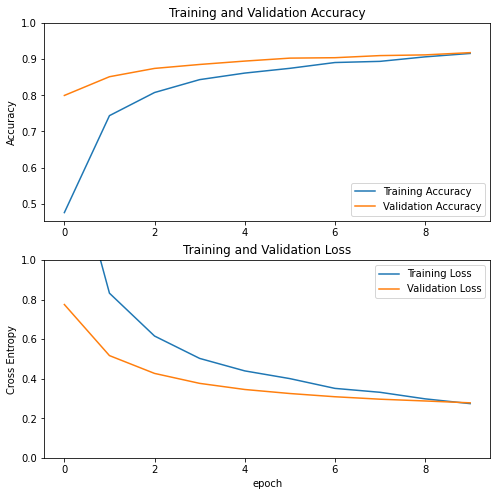

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Doing Fine Tuning

In [30]:
#Fine Tuning
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  263


In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


322/322 [==============================] - 21s 52ms/step - loss: 0.2470 - accuracy: 0.9191 - val_loss: 0.2044 - val_accuracy: 0.9369
Epoch 11/20
322/322 [==============================] - 15s 46ms/step - loss: 0.1208 - accuracy: 0.9607 - val_loss: 0.1956 - val_accuracy: 0.9455
Epoch 12/20
322/322 [==============================] - 15s 45ms/step - loss: 0.0701 - accuracy: 0.9776 - val_loss: 0.2032 - val_accuracy: 0.9393
Epoch 13/20
322/322 [==============================] - 15s 46ms/step - loss: 0.0486 - accuracy: 0.9844 - val_loss: 0.2020 - val_accuracy: 0.9529
Epoch 14/20
322/322 [==============================] - 15s 46ms/step - loss: 0.0375 - accuracy: 0.9882 - val_loss: 0.2401 - val_accuracy: 0.9385
Epoch 15/20
322/322 [==============================] - 15s 46ms/step - loss: 0.0292 - accuracy: 0.9905 - val_loss: 0.2781 - val_accuracy: 0.9362
Epoch 16/20
322/322 [==============================] - 15s 46ms/step - loss: 0.0185 - accuracy: 0.9938 - val_loss: 0.2303 - val_accuracy: 0.94

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

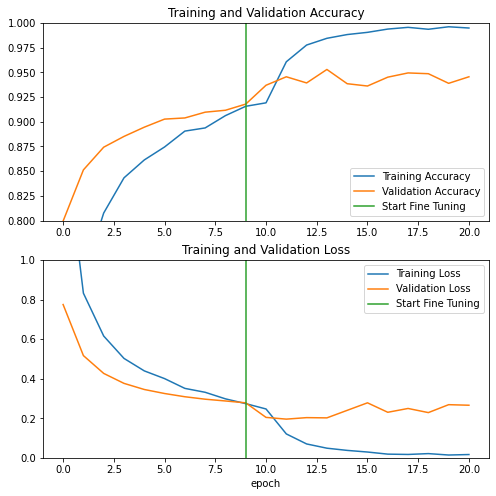

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
save_model_name = model_name + str(round(100*max(val_acc), 2)) + '.h5'
model.save(save_model_name)

In [36]:
saved_model = tf.keras.models.load_model(save_model_name)

Inference Pipeline

In [37]:
#Downloading the test dataset from drive.
!gdown --id 1uJwzf4UJlyaCajn_DkxEhh2Js69ffFnc
!gdown --id 1N5iBqzCbyXNGCX4D7kF0lctPLLE2FvNg
!unzip -o flowers_test.zip &> /dev/null

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1uJwzf4UJlyaCajn_DkxEhh2Js69ffFnc
To: /content/flowers_test.zip
100% 803k/803k [00:00<00:00, 132MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1N5iBqzCbyXNGCX4D7kF0lctPLLE2FvNg
To: /content/flowers_test.csv
100% 147/147 [00:00<00:00, 252kB/s]


In [40]:
def get_images_labels(df, classes, image_size):
    test_images = []
    image_names = []
    test_labels = []
    for index, row in df.iterrows():
        label = row[1].strip()
        image_names.append(row[0])
        img = tf.keras.utils.load_img(row[0], target_size=image_size)
        img_array = tf.keras.utils.img_to_array(img)
        img_preprocessed = preprocessing(img_array)
        test_images.append(img_preprocessed)
        test_labels.append(classes.index(label))
    return np.array(test_images), np.array(test_labels), image_names

def load_model_weights(model, weights=None):
    my_model = tf.keras.models.load_model(model)
    return my_model


test_df = pd.read_csv('flowers_test.csv')
classes = ['astilbe', 'bellflower', 'black-eyed susan', 'calendula', 'california poppy', 'carnation',
            'common daisy', 'coreopsis', 'dandelion', 'iris', 'rose', 'sunflower', 'tulip']

test_images, test_labels, image_names = get_images_labels(test_df, classes, IMG_SIZE)

model = load_model_weights(save_model_name)

for i, image in enumerate(test_images):
        predictions = model.predict(tf.expand_dims(image, 0))
        print("The image {} most likely belongs to \"{}\" with a {:.2f} percent confidence."
              .format(image_names[i], classes[np.argmax(predictions)], 100 * np.max(predictions)))

loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print('Test model, accuracy: {:5.5f}%'.format(100 * acc))

The image flowers_test/test_1.jpg most likely belongs to "common daisy" with a 100.00 percent confidence.
The image flowers_test/test_2.jpg most likely belongs to "tulip" with a 100.00 percent confidence.
The image flowers_test/test_3.jpg most likely belongs to "tulip" with a 100.00 percent confidence.
The image flowers_test/test_4.jpg most likely belongs to "rose" with a 99.91 percent confidence.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 - 1s - loss: 2.3131e-04 - accuracy: 1.0000 - 940ms/epoch - 940ms/step
Test model, accuracy: 100.00000%
